## Find Dwell Times at Polygons

An administrator may want to use Tracker data to understand what time periods a user was in a certain area. In this example, we'll detect the times the user was dwelling in a park area, which we have defined as a polygon feature. Using a polygon feature layer and a track view layer, we can perform a spatial comparison to detect the times the user entered the a certain polygon and the times the user left that polygon. This will be performed using an "intersects" filter

First, let's import the libraries we need.

In [83]:
# imports
import json
import datetime
import pendulum
import arcgis
from arcgis.gis import GIS
from arcgis.apps.tracker import TrackView

### Now, let's input our starting parameters username and org url and login to our GIS.

Note that not every parameter here is required. Username and org url are used for logging in, the polygon_item_id is the item id of the feature layer that you're going to check for intersection, the track_view_id is the item id of the tracks layer whose tracks you will check, map_center and default_zoom_level are parameters you can change for your map widget, and polygon_query will filter the types of polygons you're using.

In [84]:
# parameters
username = "admin"
org_url = "https://tracker8.dev.geocloud.com/portal"
polygon_item_id = "20690536e4a34bb6a5135a4fa1cfab65"
track_view_id = "b5650ddd34074cab965ffb8cbb9c54c9"
map_center = [43.111741, -94.251287]
default_zoom_level = 16
polygon_query = "1=1"

# optional - you can set these to None if you'd like to search tracks without any time restriction.
start_date = "04/14/2020 07:00:00"
end_date = "04/14/2020 18:30:00"
# list of available timezones - https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = "US/Eastern"

gis = GIS(org_url, username, verify_cert=False)

Enter password: ········


### Now, let's get our polygon feature layer and visualize it

We'll use our default zoom level and map center to set the map widget in the right location. Then, we'll add the parks and our track data to the map.


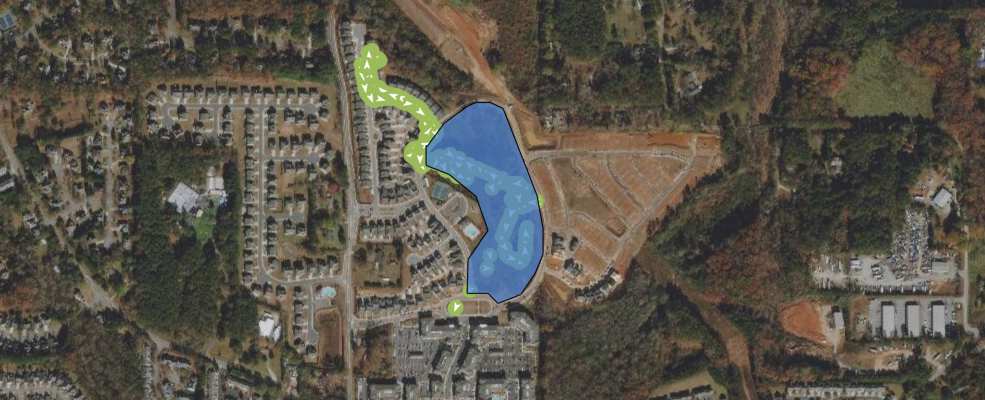

In [88]:
# get layers
parks_polygons = gis.content.get(polygon_item_id).layers[0]
track_layer = TrackView(gis.content.get(track_view_id)).tracks_layer

# map widget setup
map1 = gis.map(zoomlevel=default_zoom_level)
map1.center = map_center
map1.basemap = 'imagery'
map1.add_layer(track_layer)
map1.add_layer(parks_polygons)
map1

### We can see above that the user was moving in and out of the park quite a bit!

But it's difficult to make any assertions about time just by looking at the map widget. This is why we're going to need to query and analyze our track data. Let's form our query that we'll make against the tracks layer by converting the dates we provided above to UTC.

In [86]:
tracks_query = ""
# format to UTC
if start_date:
    local_start_date = pendulum.from_format(start_date, "MM/DD/YYYY hh:mm:ss", tz=timezone,formatter='alternative').in_tz('UTC').format("%Y-%m-%d %H:%M:%S")
    if tracks_query:
        tracks_query = tracks_query + " AND "
    tracks_query = tracks_query + f"location_timestamp > TIMESTAMP '{local_start_date}'"
if end_date:
    local_end_date = pendulum.from_format(end_date, "MM/DD/YYYY hh:mm:ss", tz=timezone,formatter='alternative').in_tz('UTC').format("%Y-%m-%d %H:%M:%S")
    if tracks_query:
        tracks_query = tracks_query + " AND "
    tracks_query = tracks_query + f"location_timestamp < TIMESTAMP '{local_end_date}'"
print("Query so far: " + tracks_query)

Query so far: location_timestamp > TIMESTAMP '2020-04-14 11:00:00' AND location_timestamp < TIMESTAMP '2020-04-14 22:30:00'


### Now, let's extract our dwell times

The code block might be large, but the logic is relatively simple. 

1. We extract the polygon features from the feature layer
2. Then, for each polygon:
    1. Extract the users who have tracks in the time period at the polygon
    2. Then, for each user:
        1. Query the layer for that user's tracks in the polygon and returned as a dataframe
        2. Query the layer for the user's tracks in a polygon that is buffered slightly and returned as a dataframe
        3. For each track point returned in the buffered dataframe:
            1. Check if the buffered point is also in the non-buffered dataframe
            2. If the track point is in the non-buffered dataframe and no start been set, use this point as the start
            3. If a start has been set and the track point is not in the non-buffered data frame, use this as the end
            4. Report the start and end date, along with the polygon id and user to the console

In [89]:
# Get each polygon
polygon_features = parks_polygons.query(polygon_query, out_sr=3857)
for feature in polygon_features:
    intersect_filter = arcgis.geometry.filters.intersects(geometry=feature.geometry, sr=3857)
    # Extract users who have tracks in the polygon for the time period
    users = track_layer.query(where=tracks_query,
                               group_by_fields_for_statistics="created_user", 
                               out_statistics=[{"statisticType": "count", "onStatisticField": "objectid", "outStatisticFieldName": "count"}],
                               geometry_filter=intersect_filter,
                               order_by="count").features
    # Iterate through each user
    i = 1
    for user in users:
        tracks_layer = tracks_query + f"AND created_user='{user.attributes['created_user']}"
        buffer_geom = arcgis.geometry.buffer(geometries=[arcgis.geometry.Polygon(json.dumps(feature.geometry))],in_sr=3857,unit=9001,distances=50,out_sr=3857)
        buffer_filter = arcgis.geometry.filters.intersects(geometry=buffer_geom[0], sr=3857)
        # Get points that intersect w polygon for this particular user
        intersect_df = track_layer.query(where=tracks_query, geometry_filter=intersect_filter, out_sr=3857, order_by_fields="location_timestamp ASC", as_df=True)
        # Get points that intersect w polygon that has 50m buffer for this particular user
        buffer_df = track_layer.query(where=tracks_query, geometry_filter=buffer_filter, out_sr=3857,order_by_fields="location_timestamp ASC", as_df=True)
        if intersect_df.shape[0] > 0:
            start_date = None
            # Iterate through each of the buffered points
            for index, row in buffer_df.iterrows():
                # If no start date but the point is in the polygon, use this as the start
                if start_date is None and row["globalid"] in intersect_df["globalid"].values:
                    start_date = row["location_timestamp"]
                # If there's a start date, check if the buffer point is not in the polygon
                elif start_date:
                    if row["globalid"] not in intersect_df["globalid"].values:
                        end_date = row["location_timestamp"]
                        print(f"Dwell Event {i}:")
                        print("Polygon ID: " + str(feature.attributes['objectid']))
                        print("User: " + str(row["created_user"]))
                        print("Start: " + str(start_date))
                        print("End: " + str(end_date))
                        print("\n")
                        start_date = None
                        i = i + 1
                # If no start date and the point is not in the park, continue on to the next pt and wait to enter polygon
                else:
                    pass
            if start_date:
                print(f"No tracks found for user {user.attributes['created_user']} leaving the area {feature.attributes['objectid']}. Entered at {start_date}")
    

Dwell Event 1:
Polygon ID: 1
User: admin
Start: 2020-04-14 14:50:51.917000
End: 2020-04-14 14:54:25.935000


Dwell Event 2:
Polygon ID: 1
User: admin
Start: 2020-04-14 14:54:30.742000
End: 2020-04-14 14:59:14.002000


